# Co-plotting split-gal4 line, hemibrain skeleton with flywire dataset

### This section contains example of split-gal4 line, skeleton from hemibrain dataset and co-plotting with a flywire instance

### Import neccesary library modules now

In [1]:
import navis
import fafbseg
import flybrains

In [2]:
import os
import numpy as np
import pandas as pd
import copy

In [3]:
import trimesh as tm

In [4]:
import navis
from vfb_connect.cross_server_tools import VfbConnect

In [35]:
from pyroglancer.localserver import startdataserver, closedataserver
from pyroglancer.flywire import flywireurl2dict, flywiredict2url, add_flywirelayer, set_flywireviewerstate
from pyroglancer.utils import pointcloud2meshes, obj2pointcloud

In [6]:
import navis.interfaces.neuprint as neu
from navis.interfaces.neuprint import NeuronCriteria as NC, SynapseCriteria as SC

### Get the Split-Gal4 line

Select the gal4 line you are interested in  for example, here I choose the line R65G01 from the neuronbridge website [here](https://neuronbridge.janelia.org/search?q=R65G01)

### Convert the gal4 line to either a mesh ( a bit efficient) or to a skeleton (involves manual processing)

*Using a mesh object*: <br>
Go to the virtualflybrain site like [here](https://v2.virtualflybrain.org/org.geppetto.frontend/geppetto?id=VFB_00023647&i=VFB_00101567,VFB_00023647) and get the vfb id here: VFB_00023647

*Using a skeleton object*: <br>
1) Download the above line as *.nrrd* by following the link to the virtualflybrain site like [here](https://v2.virtualflybrain.org/org.geppetto.frontend/geppetto?id=VFB_00023647&i=VFB_00101567,VFB_00023647)  <br>
2) Use the *.nrrd* file in FiJi and skeletonise using the simple image tracer as illustrated in this video [here](https://youtu.be/xdqAb1fC91I) <br>
3) Save the skeletonised file as *.swc* format

The rest of the tutorial only involves the mesh object based co-visualisation

In [7]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath("__file__")))))
BASE_DIR

'/Users/sri/Documents/Python/pyroglancer'

In [8]:
# vfb_neuron = navis.read_swc(swc_files, delimiter='\s+',units = 'um')
# swc_files = os.path.join(BASE_DIR, 'data/snt_tracings/VFB_00023647_snt_skel-000.swc')
# navis.health_check(vfb_neuron)
# vfb_neuron = navis.graph.clinic.merge_duplicate_nodes(vfb_neuron)

In [9]:
#utility function for transforming vfbids to meshes
def vfbid2mesh(vfb_id):
    vc = VfbConnect()
    vcinfo = vc.neo_query_wrapper.get_anatomical_individual_TermInfo([vfb_id])
    image_url = vcinfo[0]['channel_image'][0]['image']['image_folder'] + 'volume.obj'
    print('point cloud located at: ', image_url)
    pcd = obj2pointcloud(image_url)
    vfb_mesh = pointcloud2meshes(pcd, algorithm='rollingball')
    return vfb_mesh

In [10]:
vfbmeshes_dict = {}

In [11]:
vfbmeshes_dict['VFB_00023647'] = vfbid2mesh('VFB_00023647')

point cloud located at:  http://www.virtualflybrain.org/data/VFB/i/0002/3647/VFB_00101567/volume.obj
The mesh is not convex


In [12]:
vfbmeshes_dict['VFB_00020203'] = vfbid2mesh('VFB_00020203')

point cloud located at:  http://www.virtualflybrain.org/data/VFB/i/0002/0203/VFB_00101567/volume.obj
The mesh is not convex


In [13]:
jrc2018u_mesh = navis.Volume(flybrains.JRC2018U.mesh)

In [14]:
vfbmeshes_dict['VFB_00023647'].name = 'ilPN'
vfbmeshes_dict['VFB_00023647'].color = 'magenta'

In [15]:
vfbmeshes_dict['VFB_00020203'].name = 'DM5'
vfbmeshes_dict['VFB_00020203'].color = 'red'

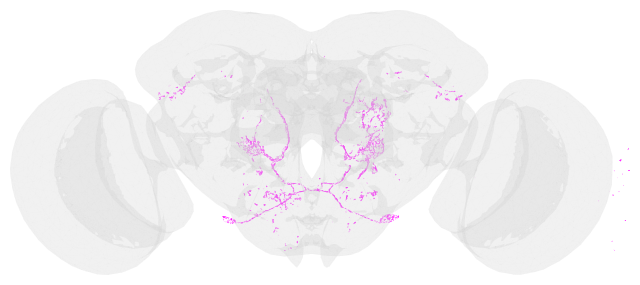

In [16]:
fig, ax = navis.plot2d([vfbmeshes_dict['VFB_00023647'],jrc2018u_mesh], method='2d')
fig.gca().invert_yaxis()
fig

### Set configurations to fetch from data from neuprint

In [17]:
neuprint_token = os.environ['NEUPRINT_APPLICATION_CREDENTIALS']
client = neu.Client('https://neuprint.janelia.org/', dataset='hemibrain:v1.1', token=neuprint_token)
client

Client("https://neuprint.janelia.org", "hemibrain:v1.1")

### Get the matching skid from neuprint using the info from neuronbridge website like [here](https://neuronbridge.janelia.org/search/lines/R65G01/matches/2711776921103892491)

In [18]:
hemibrain_skel = neu.fetch_skeletons(1912789965, heal=1000, max_threads=30)

INFO - 2021-06-07 08:45:48,706 - utils - NumExpr defaulting to 8 threads.


### Transform them to flywire space

In [19]:
#vfb_neuron=navis.xform_brain(vfb_neuron,source='JRC2018U', target='FLYWIRE')

In [20]:
vfb2flywiremeshes = {}

In [21]:
vfb2flywiremeshes['VFB_00023647'] = navis.xform_brain(vfbmeshes_dict['VFB_00023647'],source='JRC2018U', target='FLYWIRE')

Transform path: JRC2018U -> JRC2018F -> FAFB14um -> FAFB14 -> FAFB14raw -> FLYWIREraw -> FLYWIRE


In [22]:
vfb2flywiremeshes['VFB_00020203'] = navis.xform_brain(vfbmeshes_dict['VFB_00020203'],source='JRC2018U', target='FLYWIRE')

Transform path: JRC2018U -> JRC2018F -> FAFB14um -> FAFB14 -> FAFB14raw -> FLYWIREraw -> FLYWIRE


In [23]:
hemibrain2flywire_skel=navis.xform_brain(hemibrain_skel,source='JRCFIB2018Fraw', target='FLYWIRE')

Transform path: JRCFIB2018Fraw -> JRCFIB2018F -> JRCFIB2018Fum -> JRC2018F -> FAFB14um -> FAFB14 -> FAFB14raw -> FLYWIREraw -> FLYWIRE


### Start the dataserver to host precomputed data

In [37]:
startdataserver()

Closing server at http://127.0.0.1:8000
Cleaning directory at /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmpd8yw3_fb
Serving data from:  /var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmph11kfa8u
Serving directory at http://127.0.0.1:8000


### Get the url from flywire to append data onto

In [38]:
shorturl = 'https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5169621741076480'
#This flywire segments has some stuff similar (in blue), you will notice their closeness in the final plot

### Add bodyids to flywire layers

In [39]:
# vfb_neuron.id = 1234
# matchingneurons = navis.NeuronList(vfb_neuron)
# matchingneurons += hemibrain2flywire_skel

In [40]:
tmpviewer = add_flywirelayer(flywireurl2dict(shorturl), layer_kws = {'type': 'skeletons',
                                                                     'source': hemibrain2flywire_skel,
                                                                     'color': ['red'],
                                                                     'name':'hemibrain_1912789965'
                                                                     #'space': 'FAFBv14.1',
                                                                     #'annotationstatetype': 'precomputed'
                                                                    }) 
#'alpha': 0.3, doesn't work yet in skeleton layers..

/private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmph11kfa8u/precomputed/hemibrain_1912789965/skeletons/1912789965
creating: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmph11kfa8u/precomputed/hemibrain_1912789965/skeletons/seg_props
{'1912789965': ['#ff0000']}
flywire url at: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5828375906091008


In [41]:
vfb2flywiremeshes['VFB_00023647'].id = 23647
vfb2flywiremeshes['VFB_00020203'].id = 20203

In [42]:
vfb2flywiremeshes

{'VFB_00023647': <navis.Volume(name=None, id=23647, color=(0.85, 0.85, 0.85, 0.2), vertices.shape=(12213, 3), faces.shape=(12861, 3))>,
 'VFB_00020203': <navis.Volume(name=None, id=20203, color=(0.85, 0.85, 0.85, 0.2), vertices.shape=(30152, 3), faces.shape=(30941, 3))>}

In [43]:
tmpviewer = add_flywirelayer(flywireurl2dict(tmpviewer), layer_kws = {'type': 'volumes','name': 'vfb_' + vfbmeshes_dict['VFB_00023647'].name,
                                                        'source': vfb2flywiremeshes['VFB_00023647'],'color': 'magenta'})

mesh/23647
Seg id is: 23647
Full filepath: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmph11kfa8u/precomputed/vfb_ilPN/mesh/23647
creating: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmph11kfa8u/precomputed/vfb_ilPN/mesh/segment_properties
creating: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmph11kfa8u/precomputed/vfb_ilPN/mesh/segment_names
flywire url at: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5341474052898816


In [44]:
# if you want to add the next vfb neuron..
tmpviewer = add_flywirelayer(flywireurl2dict(tmpviewer), layer_kws = {'type': 'volumes','name': 'vfb_' + vfbmeshes_dict['VFB_00020203'].name,
                                                        'source': vfb2flywiremeshes['VFB_00020203'],'color': 'blue'})

mesh/20203
Seg id is: 20203
Full filepath: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmph11kfa8u/precomputed/vfb_DM5/mesh/20203
creating: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmph11kfa8u/precomputed/vfb_DM5/mesh/segment_properties
creating: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmph11kfa8u/precomputed/vfb_DM5/mesh/segment_names
flywire url at: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/4650243190685696


In [45]:
#tmpviewer,shorturl = set_flywireviewerstate(tmpviewer, axis_lines=False, bounding_box=False)

flywire url at: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5829114439139328


127.0.0.1 - - [07/Jun/2021 08:52:21] "GET /precomputed/hemibrain_1912789965/skeletons//info HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2021 08:52:21] "GET /precomputed/vfb_ilPN/mesh/info HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2021 08:52:21] "GET /precomputed/vfb_DM5/mesh/info HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2021 08:52:21] "GET /precomputed/vfb_ilPN/mesh/23647:0 HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2021 08:52:21] "GET /precomputed/vfb_DM5/mesh/20203:0 HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2021 08:52:21] "GET /precomputed/hemibrain_1912789965/skeletons//1912789965 HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2021 08:52:21] "GET /precomputed/vfb_ilPN/mesh/23647 HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2021 08:52:21] "GET /precomputed/vfb_DM5/mesh/20203 HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2021 08:53:42] "GET /precomputed/hemibrain_1912789965/skeletons//info HTTP/1.1" 304 -
127.0.0.1 - - [07/Jun/2021 08:53:42] "GET /precomputed/vfb_ilPN/mesh/info HTTP/1.1" 304 -
127.0.0.1 - - [07/Jun/2021 08:53:42

In [ ]:
# # if you want to add everything in one tab (source)..
# tmpviewer = add_flywirelayer(flywireurl2dict(tmpviewer), layer_kws = {'type': 'volumes',
#                                                                       'name': 'vfb_meshes',
#                                                                       'source': list(vfb2flywiremeshes.values()),
#                                                                       'color': ['magenta','blue']})

### Screenshot of the flywire instance

#### The magenta neuron is the gal4line from vfb whereas the red neuron is the corresponding match from hemibrain according to neuronbridge and the green neuron is the corresponding flywire segment that is closest match

![alt text](pics/gal4line_hemibrain2flywire.png "hemibrain2flywire")

### Close the dataserver

In [46]:
closedataserver()

Closing server at http://127.0.0.1:8000
Cleaning directory at /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmph11kfa8u
